In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import matplotlib.pyplot as plt

# 1. Circle dataset

In [157]:
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, noise=.07,factor=0.5,random_state=42)

dataset_circles = noisy_circles[0]

labels = noisy_circles[1]

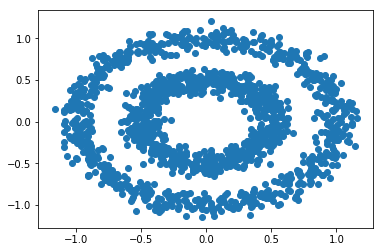

In [158]:
plt.scatter(dataset_circles[:,0], dataset_circles[:,1])
plt.show()

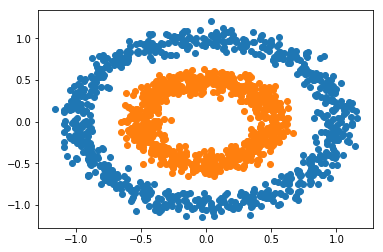

In [159]:
data_0 = dataset_circles[labels == 0]
plt.scatter(data_0[:,0], data_0[:,1])
data_1 = dataset_circles[labels == 1]
plt.scatter(data_1[:,0], data_1[:,1])
plt.show()

## Step1: Make Laplacian Matrix

### dataset -> similarity matrix

In [34]:
def similarity_matrix(df,alpha):
    n=len(df)
    S = np.empty([n,n])
    
    for i in range(n):
        for j in range(n):
            S[i,j]=np.exp(-alpha*np.square(np.linalg.norm(df[i,:]-df[j,:])))
            
    return S

In [36]:
S = similarity_matrix(dataset_circles, 3)
S[:8,:8]

array([[1.00000000e+00, 1.33336460e-01, 4.65169074e-01, 4.10339818e-01,
        1.45158502e-01, 1.28870413e-01, 8.69927109e-01, 2.33696552e-03],
       [1.33336460e-01, 1.00000000e+00, 3.75261300e-02, 1.46758337e-02,
        1.79978027e-02, 1.60950900e-01, 1.02787075e-01, 1.41524032e-01],
       [4.65169074e-01, 3.75261300e-02, 1.00000000e+00, 9.20080907e-01,
        7.36248644e-01, 5.85271435e-03, 2.17601412e-01, 6.60747793e-05],
       [4.10339818e-01, 1.46758337e-02, 9.20080907e-01, 1.00000000e+00,
        5.98650658e-01, 3.57022389e-03, 2.01808483e-01, 1.84054298e-05],
       [1.45158502e-01, 1.79978027e-02, 7.36248644e-01, 5.98650658e-01,
        1.00000000e+00, 6.49817841e-04, 4.51702894e-02, 1.11676450e-05],
       [1.28870413e-01, 1.60950900e-01, 5.85271435e-03, 3.57022389e-03,
        6.49817841e-04, 1.00000000e+00, 2.54341634e-01, 1.54245023e-01],
       [8.69927109e-01, 1.02787075e-01, 2.17601412e-01, 2.01808483e-01,
        4.51702894e-02, 2.54341634e-01, 1.00000000e+00, 4.

### similarity matrix -> affinity matrix

In [35]:
def affinity_matrix(S,n_neighbors):
    n = len(S)
    if n_neighbors>=n:
        A = S
    else:
        
        A = np.empty([n,n])
    
        for i in range(n):
            best_similar=sorted(S[i,:],reverse=True)[:n_neighbors]
            
            for value in best_similar:
                index = S[i,:].argsort()[-n_neighbors:]
                A[i,index] = S[i,index]
               
    
    return A    

In [38]:
A = affinity_matrix(S,5)
A

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [45]:
np.where(A[500,:]!=0)

(array([ 115,  310,  481,  500, 1389], dtype=int64),)

### affinity matrix -> laplacian matrix

In [40]:
n =len(A)

d=[]
for i in range(n):
    d.append(np.sum(A[i,:]))

D=np.diag(d)
D

array([[4.99432393, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 4.99617609, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 4.970109  , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 4.98379726, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 4.98019205,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        4.98845977]])

In [41]:
L=D-A
L

array([[3.99432393, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.99617609, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 3.970109  , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 3.98379726, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 3.98019205,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        3.98845977]])

In [46]:
def make_laplacian(df, alpha, n_neighbors):
    S = similarity_matrix(df,alpha)
    A = affinity_matrix(S,n_neighbors)
    
    n =len(A)
    d=[]
    for i in range(n):
        d.append(np.sum(A[i,:]))

    D=np.diag(d)
    
    L = D - A
    
    return L 

In [123]:
L = make_laplacian(dataset_circles,alpha=5, n_neighbors=7)
L

# 5,7 쪼금 아쉽
# 3,7 조금아쉽

array([[8.93869259, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 8.96994981, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 8.7917274 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 8.91333477, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 8.87105474,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        8.88025888]])

## Step2: Eigenvalue Decomposition

In [48]:
from numpy import linalg as LA

In [49]:
def eig_sort(matrix):
    eigen_value, eigen_vector = LA.eig(matrix)
    
    index = eigen_value.argsort()
    
    eigen_value=eigen_value[index]
    eigen_vector=eigen_vector[:,index]
    
    return eigen_value, eigen_vector

In [124]:
result = eig_sort(L)[1]

In [125]:
Z = result[:,:2]

## Step3: K-means

In [52]:
from sklearn.cluster import KMeans

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\numpy\core\numeric.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


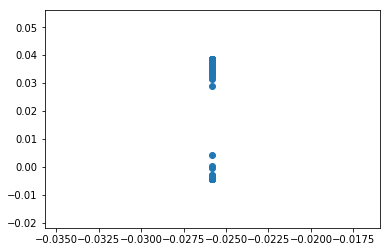

In [126]:
plt.scatter(x=Z[:,0],y=Z[:,1])
plt.show()

In [120]:
kmeans = KMeans(n_clusters=2,random_state=42).fit(Z)

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


In [121]:
kmeans.labels_

array([0, 0, 1, ..., 0, 0, 0])

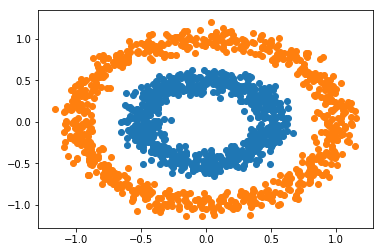

In [122]:
data_0 = dataset_circles[kmeans.labels_==0]
plt.scatter(data_0[:,0], data_0[:,1])
data_1 = dataset_circles[kmeans.labels_==1]
plt.scatter(data_1[:,0], data_1[:,1])
plt.show()

# 2.Moon Dataset

In [160]:
n_samples = 1500
noisy_circles = datasets.make_moons(n_samples=n_samples, noise=.07, random_state=42)

dataset_moons = noisy_circles[0]

labels = noisy_circles[1]

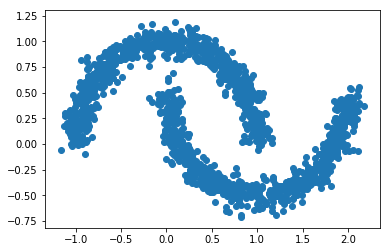

In [161]:
plt.scatter(dataset_moons[:,0], dataset_moons[:,1])
plt.show()

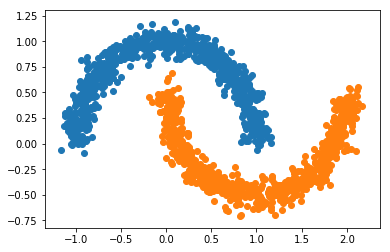

In [163]:
data_0 = dataset_moons[labels == 0]
plt.scatter(data_0[:,0], data_0[:,1])
data_1 = dataset_moons[labels == 1]
plt.scatter(data_1[:,0], data_1[:,1])
plt.show()

## Step1: Make Laplacian Matrix

In [139]:
L = make_laplacian(dataset_moons,alpha=5, n_neighbors=7)
L

array([[5.9916541 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 5.99317491, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 5.99227441, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 5.98920995, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 5.96909023,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        5.99405372]])

## Step2: Eigenvalue Decomposition

In [140]:
result = eig_sort(L)[1]

In [153]:
Z = result[:,[0,1]]

## Step3: K-means

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\numpy\core\numeric.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


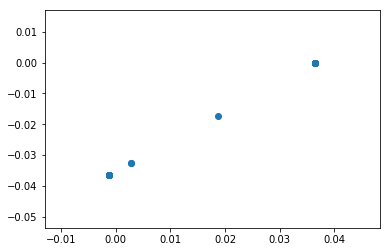

In [154]:
plt.scatter(x=Z[:,0],y=Z[:,1])
plt.show()

In [155]:
kmeans = KMeans(n_clusters=2,random_state=42).fit(Z)

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


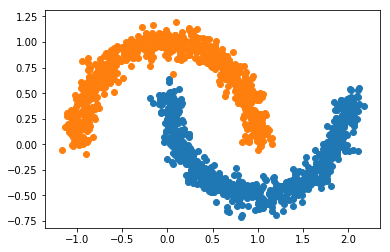

In [156]:
data_0 = dataset_moons[kmeans.labels_==0]
plt.scatter(data_0[:,0], data_0[:,1])
data_1 = dataset_moons[kmeans.labels_==1]
plt.scatter(data_1[:,0], data_1[:,1])
plt.show()